# Chains in LangChain

## Outline

* LLMChain
* Sequential Chains
  * SimpleSequentialChain
  * SequentialChain
* Router Chain

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import openai
import os
import json

# Open the JSON file
with open('/Users/edwin/Repositories/api_keys.json') as file:
    data = json.load(file)

# Access the API keys
openai.api_key= data['apiKeys']['OpenAI']

In [3]:
import pandas as pd
df = pd.read_csv('Data.csv')

In [4]:
df.head()

,Product,Review
0,Queen Size Sheet Set,I ordered a king size set. My only criticism w...
1,Waterproof Phone Pouch,"I loved the waterproof sac, although the openi..."
2,Luxury Air Mattress,This mattress had a small hole in the top of i...
3,Pillows Insert,This is the best throw pillow fillers on Amazo...
4,Milk Frother Handheld\r\n,I loved this product. But they only seem to l...


## LLMChain

In [5]:
from langchain.chat_models import ChatOpenAI 
from langchain.prompts import ChatPromptTemplate 
from langchain.chains import LLMChain 

In [7]:
llm = ChatOpenAI(temperature=0.9,openai_api_key=data['apiKeys']['OpenAI']) #initialize the language model with a high temperature


In [8]:
prompt = ChatPromptTemplate.from_template(
    "What is the best name to describe \
    a company that makes {product}?"
)

In [9]:
chain = LLMChain(llm=llm, prompt=prompt) #Combination of llm and the prompt

In [13]:
product = "Waterproof Phone Pouch"
chain.run(product) 

'AquaShield Phone Pouches'

## SimpleSequentialChain

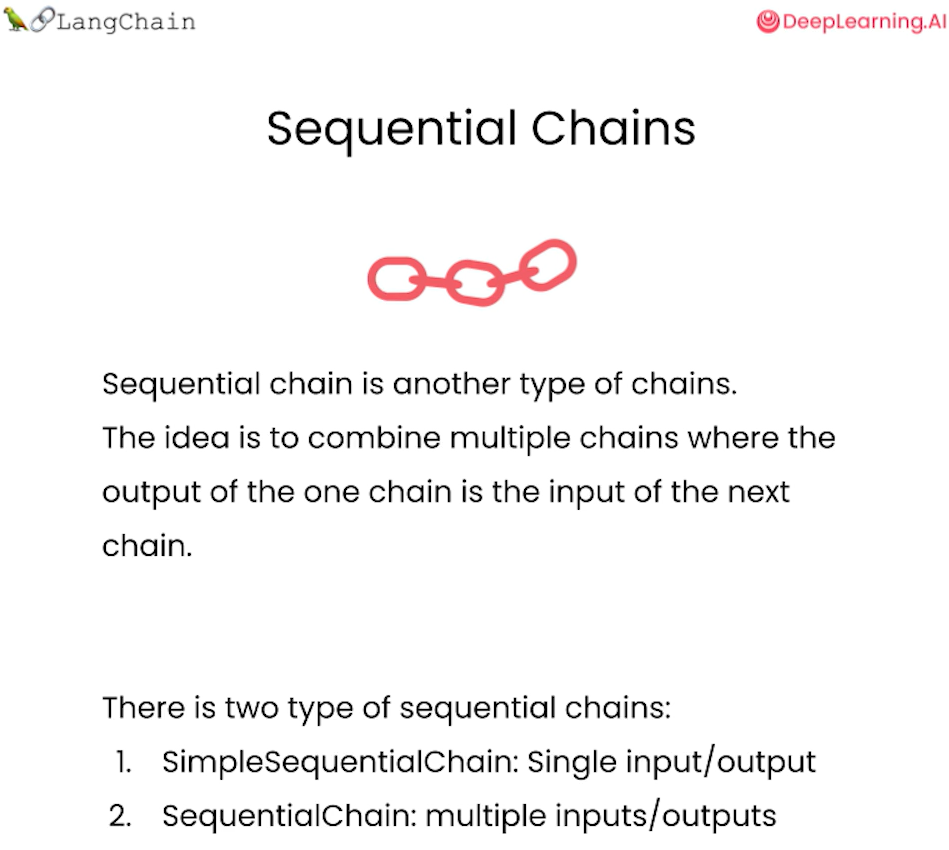

In [12]:
from langchain.chains import SimpleSequentialChain

In [15]:
llm = ChatOpenAI(temperature=0.9,openai_api_key=data['apiKeys']['OpenAI'])

# prompt template 1
first_prompt = ChatPromptTemplate.from_template(
    "What is the best name to describe \
    a company that makes {product}?"
)

# Chain 1
chain_one = LLMChain(llm=llm, prompt=first_prompt)

In [16]:

# prompt template 2
second_prompt = ChatPromptTemplate.from_template(
    "Write a 20 words description for the following \
    company:{company_name}"
)
# chain 2
chain_two = LLMChain(llm=llm, prompt=second_prompt)

In [17]:
overall_simple_chain = SimpleSequentialChain(chains=[chain_one, chain_two],
                                             verbose=True
                                            )

In [18]:
overall_simple_chain.run(product)



> Entering new  chain...
AquaGuard Phone Pouches.
AquaGuard Phone Pouches offers waterproof and durable phone cases that protect your device from water, sand, dirt, and other environmental hazards.

> Finished chain.


'AquaGuard Phone Pouches offers waterproof and durable phone cases that protect your device from water, sand, dirt, and other environmental hazards.'

## SequentialChain

In [19]:
from langchain.chains import SequentialChain

We first want to get the translation of the review to english

In [21]:
llm = ChatOpenAI(temperature=0.9,openai_api_key=data['apiKeys']['OpenAI'])

# prompt template 1: translate to english
first_prompt = ChatPromptTemplate.from_template(
    "Translate the following review to english:"
    "\n\n{Review}"
)
# chain 1: input= Review and output= English_Review
chain_one = LLMChain(llm=llm, prompt=first_prompt, 
                     output_key="English_Review"
                    )


Then, summarize the review. Notice that you take the output of the last prompt for the next one.

In [22]:
second_prompt = ChatPromptTemplate.from_template(
    "Can you summarize the following review in 1 sentence:"
    "\n\n{English_Review}"
)
# chain 2: input= English_Review and output= summary
chain_two = LLMChain(llm=llm, prompt=second_prompt, 
                     output_key="summary"
                    )


Get the languaage of the review

In [23]:
# prompt template 3: translate to english
third_prompt = ChatPromptTemplate.from_template(
    "What language is the following review:\n\n{Review}"
)
# chain 3: input= Review and output= language
chain_three = LLMChain(llm=llm, prompt=third_prompt,
                       output_key="language"
                      )


And finally write a follow up.

In [24]:

# prompt template 4: follow up message
fourth_prompt = ChatPromptTemplate.from_template(
    "Write a follow up response to the following "
    "summary in the specified language:"
    "\n\nSummary: {summary}\n\nLanguage: {language}"
)
# chain 4: input= summary, language and output= followup_message
chain_four = LLMChain(llm=llm, prompt=fourth_prompt,
                      output_key="followup_message"
                     )


In [32]:
# overall_chain: input= Review 
# and output= English_Review,summary, followup_message
overall_chain = SequentialChain(
    chains=[chain_one, chain_two, chain_three, chain_four],
    input_variables=["Review"],
    output_variables=["English_Review", "summary","followup_message","language"],
    verbose=True
)

In [33]:
review = df.Review[5]
overall_chain(review)



> Entering new  chain...


Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised APIConnectionError: Error communicating with OpenAI: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')).



> Finished chain.


{'Review': "Je trouve le goût médiocre. La mousse ne tient pas, c'est bizarre. J'achète les mêmes dans le commerce et le goût est bien meilleur...\r\nVieux lot ou contrefaçon !?",
 'English_Review': '"I find the taste mediocre. The foam doesn\'t last, it\'s strange. I buy the same ones in stores and the taste is much better... Old batch or counterfeit!?"',
 'summary': "The reviewer finds the taste of the product mediocre and suspects that it might be an old batch or counterfeit because the foam doesn't last, unlike the ones they buy in stores which taste much better.",
 'followup_message': "Réponse: Merci d'avoir partagé votre avis sur le produit. Nous sommes désolés d'apprendre que ce dernier ne répond pas à vos attentes en termes de goût et de qualité. Nous prenons cela très au sérieux et souhaiterions avoir plus de détails sur l'expérience que vous avez eue avec le produit. Pourriez-vous nous en dire plus sur la date d'expiration de votre achat et sur l'endroit où vous l'avez acheté

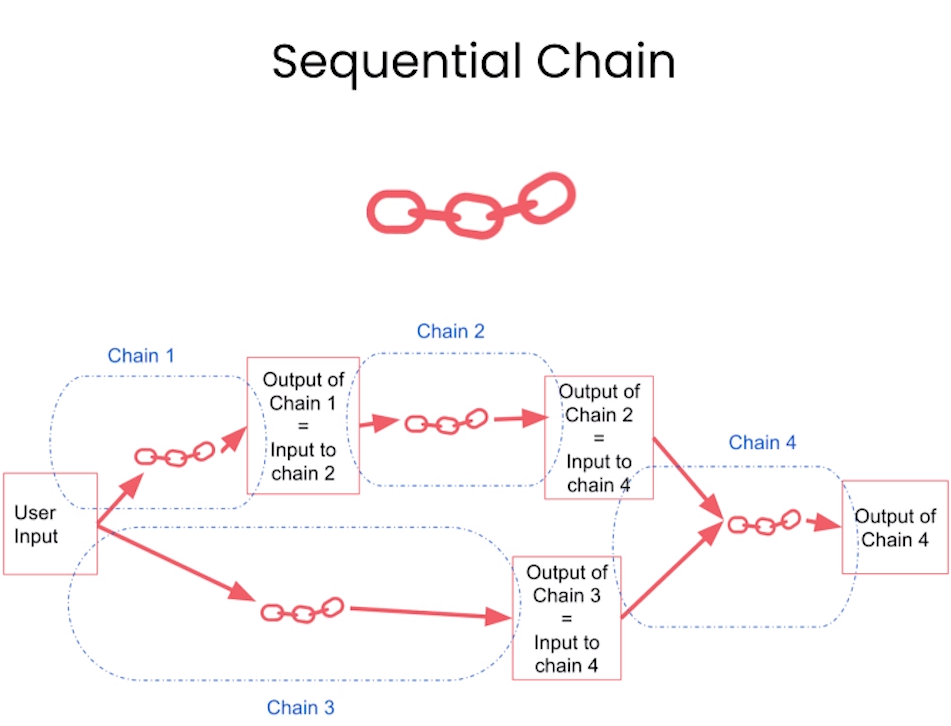

## Router Chain

You could select a template, for example, if you want someone to help you with physics, you could select the prompt that is a physics professor; or if you want about computer science, you could do about it.

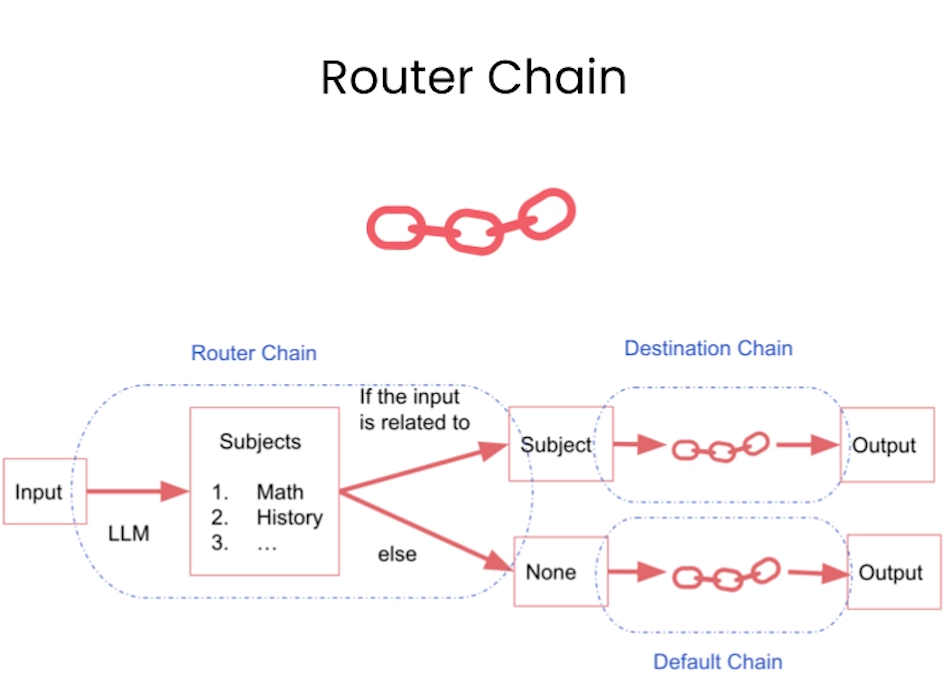

In [34]:
physics_template = """You are a very smart physics professor. \
You are great at answering questions about physics in a concise\
and easy to understand manner. \
When you don't know the answer to a question you admit\
that you don't know.

Here is a question:
{input}"""


math_template = """You are a very good mathematician. \
You are great at answering math questions. \
You are so good because you are able to break down \
hard problems into their component parts, 
answer the component parts, and then put them together\
to answer the broader question.

Here is a question:
{input}"""

history_template = """You are a very good historian. \
You have an excellent knowledge of and understanding of people,\
events and contexts from a range of historical periods. \
You have the ability to think, reflect, debate, discuss and \
evaluate the past. You have a respect for historical evidence\
and the ability to make use of it to support your explanations \
and judgements.

Here is a question:
{input}"""


computerscience_template = """ You are a successful computer scientist.\
You have a passion for creativity, collaboration,\
forward-thinking, confidence, strong problem-solving capabilities,\
understanding of theories and algorithms, and excellent communication \
skills. You are great at answering coding questions. \
You are so good because you know how to solve a problem by \
describing the solution in imperative steps \
that a machine can easily interpret and you know how to \
choose a solution that has a good balance between \
time complexity and space complexity. 

Here is a question:
{input}"""

In [35]:
prompt_infos = [
    {
        "name": "physics", 
        "description": "Good for answering questions about physics", 
        "prompt_template": physics_template
    },
    {
        "name": "math", 
        "description": "Good for answering math questions", 
        "prompt_template": math_template
    },
    {
        "name": "History", 
        "description": "Good for answering history questions", 
        "prompt_template": history_template
    },
    {
        "name": "computer science", 
        "description": "Good for answering computer science questions", 
        "prompt_template": computerscience_template
    }
]

In [36]:
from langchain.chains.router import MultiPromptChain
from langchain.chains.router.llm_router import LLMRouterChain,RouterOutputParser
from langchain.prompts import PromptTemplate

In [38]:
llm = ChatOpenAI(temperature=0,openai_api_key=data['apiKeys']['OpenAI'])

In [39]:

destination_chains = {}
for p_info in prompt_infos:
    name = p_info["name"]
    prompt_template = p_info["prompt_template"]
    prompt = ChatPromptTemplate.from_template(template=prompt_template)
    chain = LLMChain(llm=llm, prompt=prompt)
    destination_chains[name] = chain  
    
destinations = [f"{p['name']}: {p['description']}" for p in prompt_infos]
destinations_str = "\n".join(destinations)

In [40]:
default_prompt = ChatPromptTemplate.from_template("{input}")
default_chain = LLMChain(llm=llm, prompt=default_prompt)

In [41]:
MULTI_PROMPT_ROUTER_TEMPLATE = """Given a raw text input to a \
language model select the model prompt best suited for the input. \
You will be given the names of the available prompts and a \
description of what the prompt is best suited for. \
You may also revise the original input if you think that revising\
it will ultimately lead to a better response from the language model.

<< FORMATTING >>
Return a markdown code snippet with a JSON object formatted to look like:
```json
{{{{
    "destination": string \ name of the prompt to use or "DEFAULT"
    "next_inputs": string \ a potentially modified version of the original input
}}}}
```

REMEMBER: "destination" MUST be one of the candidate prompt \
names specified below OR it can be "DEFAULT" if the input is not\
well suited for any of the candidate prompts.
REMEMBER: "next_inputs" can just be the original input \
if you don't think any modifications are needed.

<< CANDIDATE PROMPTS >>
{destinations}

<< INPUT >>
{{input}}

<< OUTPUT (remember to include the ```json)>>"""

In [42]:
router_template = MULTI_PROMPT_ROUTER_TEMPLATE.format(
    destinations=destinations_str
)
router_prompt = PromptTemplate(
    template=router_template,
    input_variables=["input"],
    output_parser=RouterOutputParser(), #This allows the system to know which chain to choose
)

router_chain = LLMRouterChain.from_llm(llm, router_prompt)

In [43]:
chain = MultiPromptChain(router_chain=router_chain, 
                         destination_chains=destination_chains, 
                         default_chain=default_chain, verbose=True
                        )

In [44]:
chain.run("What is black body radiation?")



> Entering new  chain...


Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised APIConnectionError: Error communicating with OpenAI: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')).


physics: {'input': 'What is black body radiation?'}
> Finished chain.


"Black body radiation refers to the electromagnetic radiation emitted by a perfect black body, which is an object that absorbs all radiation that falls on it and emits radiation at all wavelengths. The radiation emitted by a black body depends only on its temperature and follows a specific distribution known as Planck's law. This type of radiation is important in understanding the behavior of stars, as well as in the development of technologies such as incandescent light bulbs and infrared cameras."

In [45]:
chain.run("what is 2 + 2")



> Entering new  chain...


Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised APIConnectionError: Error communicating with OpenAI: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')).


math: {'input': 'what is 2 + 2'}
> Finished chain.


'As an AI language model, I can answer this question easily. The answer to 2 + 2 is 4.'

In [46]:
chain.run("Why does every cell in our body contain DNA?")



> Entering new  chain...
None: {'input': 'Why does every cell in our body contain DNA?'}
> Finished chain.


'Every cell in our body contains DNA because DNA carries the genetic information that determines the characteristics and functions of each cell. DNA contains the instructions for the synthesis of proteins, which are essential for the structure and function of cells. Additionally, DNA is responsible for the transmission of genetic information from one generation to the next. Therefore, every cell in our body needs DNA to carry out its specific functions and to maintain the integrity of the organism as a whole.'